In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
import folium
import wolta.data_tools as wdt
import wolta.model_tools as wmt
import catboost as cb
from sklearn.model_selection import train_test_split
import shap
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn import metrics
sns.set_theme(style='whitegrid', font_scale=1.3, palette='Set2')



/Users/andrejegorov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load & get familiar with data

In [2]:
df = pd.read_csv('house_data.csv')
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


In [3]:
df.drop(['date'], axis=1, inplace=True)

In [4]:
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
count,4.600000e+03,4600.000000,4600.000000,4600.000000,4.600000e+03,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000,4600.000000
mean,5.519630e+05,3.400870,2.160815,2139.346957,1.485252e+04,1.512065,0.007174,0.240652,3.451739,1827.265435,312.081522,1970.786304,808.608261
std,5.638347e+05,0.908848,0.783781,963.206916,3.588444e+04,0.538288,0.084404,0.778405,0.677230,862.168977,464.137228,29.731848,979.414536
min,0.000000e+00,0.000000,0.000000,370.000000,6.380000e+02,1.000000,0.000000,0.000000,1.000000,370.000000,0.000000,1900.000000,0.000000
25%,3.228750e+05,3.000000,1.750000,1460.000000,5.000750e+03,1.000000,0.000000,0.000000,3.000000,1190.000000,0.000000,1951.000000,0.000000
50%,4.609435e+05,3.000000,2.250000,1980.000000,7.683000e+03,1.500000,0.000000,0.000000,3.000000,1590.000000,0.000000,1976.000000,0.000000
75%,6.549625e+05,4.000000,2.500000,2620.000000,1.100125e+04,2.000000,0.000000,0.000000,4.000000,2300.000000,610.000000,1997.000000,1999.000000
max,2.659000e+07,9.000000,8.000000,13540.000000,1.074218e+06,3.500000,1.000000,4.000000,5.000000,9410.000000,4820.000000,2014.000000,2014.000000


In [5]:
#check for nulls and duplicates
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

In [6]:
df.duplicated().value_counts()

False    4600
Name: count, dtype: int64

In [7]:
#drop records with price = 0
df = df.query('price!=0')

## visualize features/target relationships for potential importance identification

<Axes: xlabel='sqft_living', ylabel='Count'>

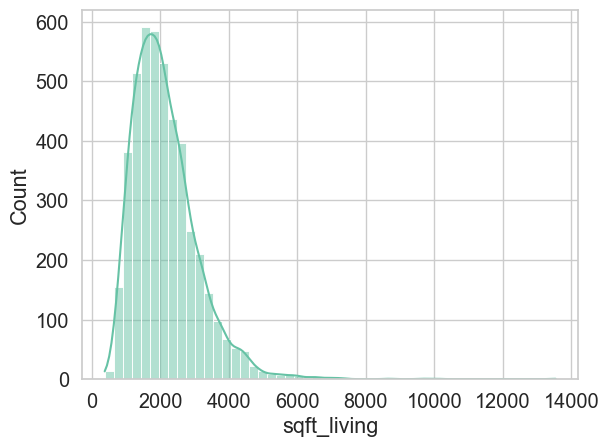

In [8]:
sns.histplot(data=df['sqft_living'],bins=50,kde=True)

In [9]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'yr_built', 'yr_renovated', 'street', 'city', 'statezip', 'country'],
      dtype='object')

In [10]:
df.view.value_counts()

view
0    4103
2     201
3     115
1      69
4      63
Name: count, dtype: int64

In [11]:
features  = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'condition' ]

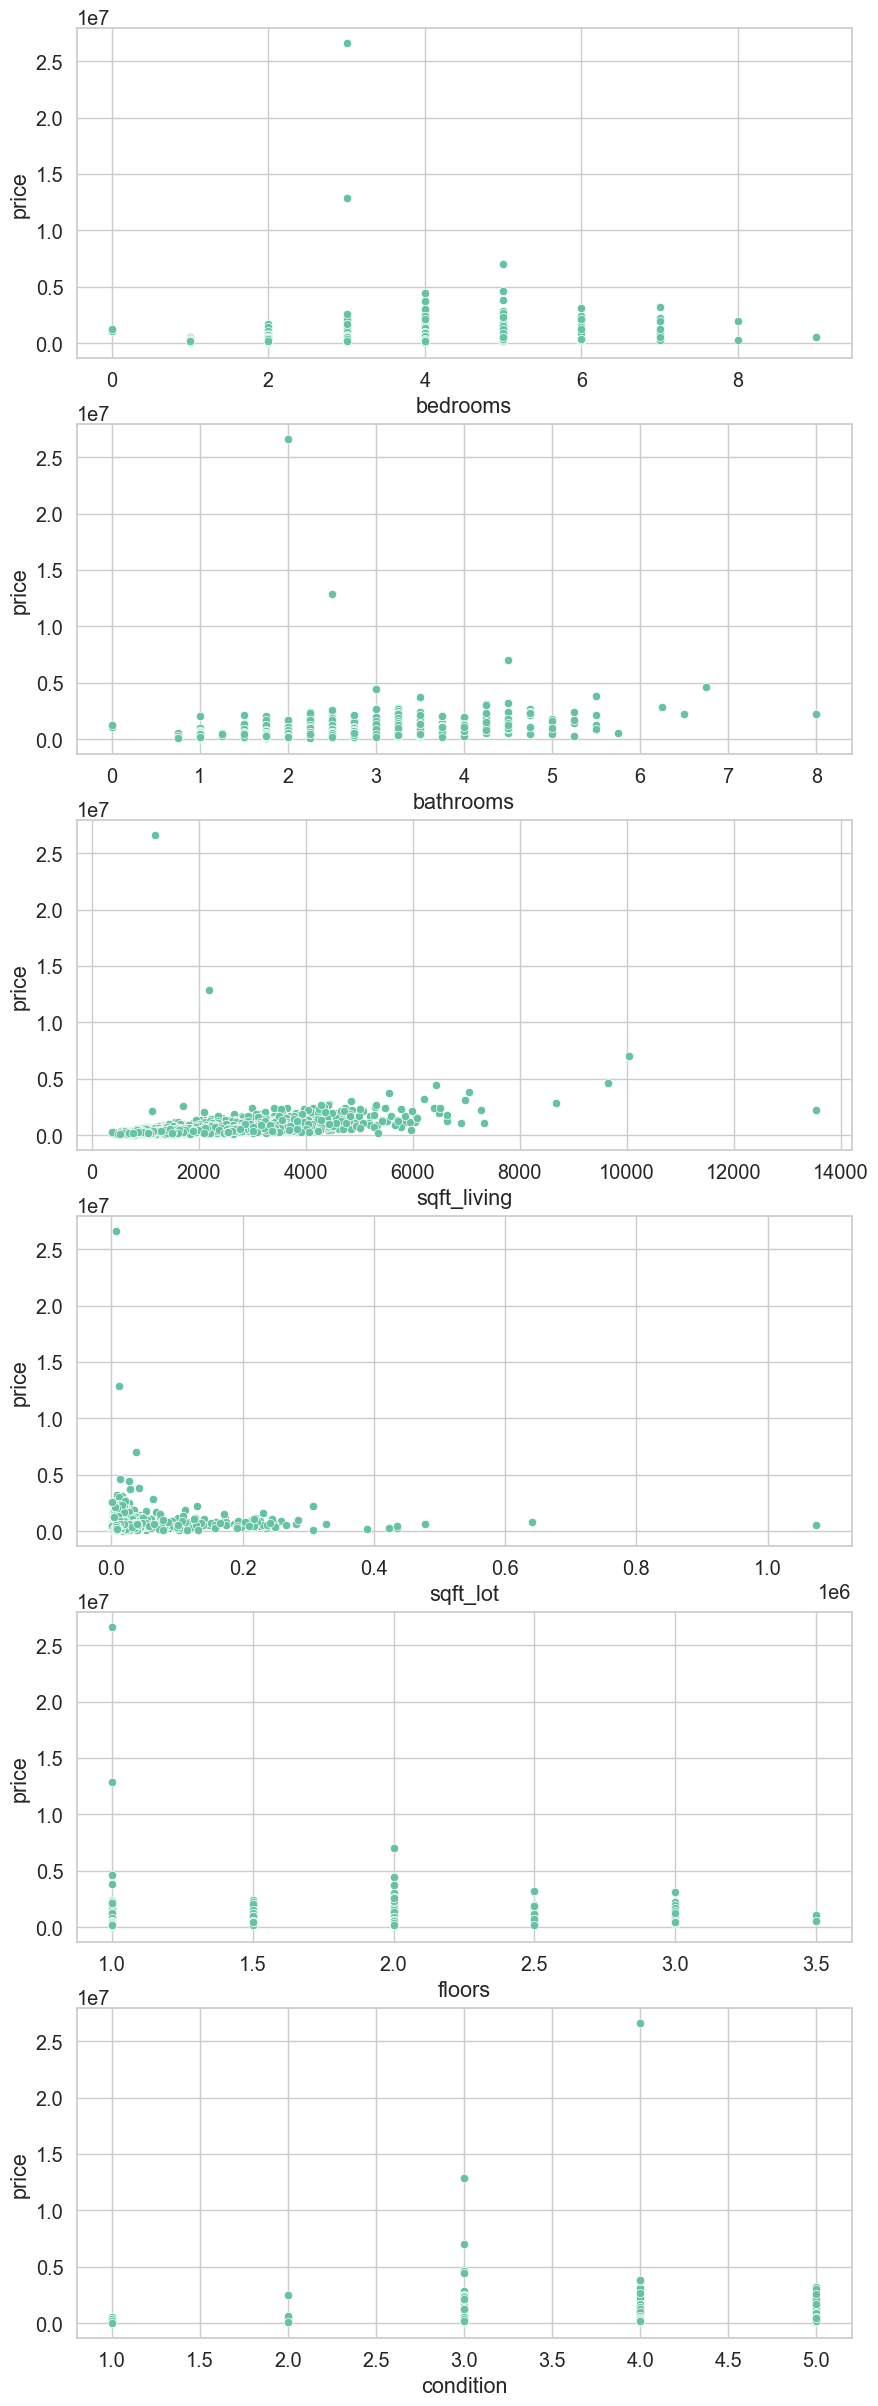

In [12]:
fig, axes = plt.subplots(6,1,figsize=(10,30))

for i in range(len(features)):
    sns.scatterplot(data=df,x=features[i],y='price',ax=axes[i])

<Axes: xlabel='sqft_living', ylabel='price'>

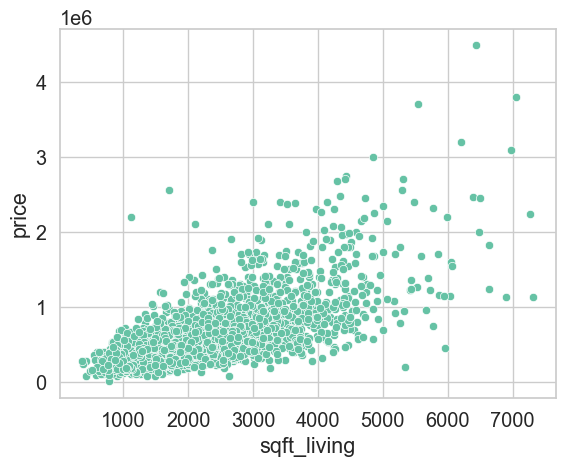

In [13]:
sns.scatterplot(data=df.query('price<5*(10**6) and sqft_living<8000'),x='sqft_living',y='price')

In [14]:
#identify features that should be deleted and drop them
df = wdt.list_deletings(df)

The maximum tolerated null value amount is 910
country will be deleted because it has single value
The maximum tolerated unique value amount is 455 in string data
street might be deleted because it has 4476 unique values and this is 4021 values more than tolerance


In [15]:
del df['street']
y = df['price'].values
del df['price']
del df['city']
del df['statezip']
X = df.values
df

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005
1,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0
2,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0
3,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0
4,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992
...,...,...,...,...,...,...,...,...,...,...,...,...
4595,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979
4596,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009
4597,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0
4598,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0


## prepare data for model training

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)
del X, y

In [17]:
train_dataset = cb.Pool(X_train, y_train) 
test_dataset = cb.Pool(X_test, y_test)

## training catboost model 

In [18]:
model = cb.CatBoostRegressor(loss_function='RMSE')

In [19]:
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset)

0:	learn: 685135.5649748	test: 1189264.7680922	best: 1189264.7680922 (0)	total: 58.8ms	remaining: 5.82s
1:	learn: 670948.0607626	test: 1180819.8399836	best: 1180819.8399836 (1)	total: 59.6ms	remaining: 2.92s
2:	learn: 657236.0937215	test: 1172673.7980325	best: 1172673.7980325 (2)	total: 60.5ms	remaining: 1.96s
3:	learn: 643874.1195970	test: 1164934.5623456	best: 1164934.5623456 (3)	total: 61.9ms	remaining: 1.49s
4:	learn: 631875.3203653	test: 1157789.9671509	best: 1157789.9671509 (4)	total: 62.5ms	remaining: 1.19s
5:	learn: 619839.8135852	test: 1150817.7555904	best: 1150817.7555904 (5)	total: 62.9ms	remaining: 986ms
6:	learn: 609552.3122759	test: 1144802.7858341	best: 1144802.7858341 (6)	total: 63.3ms	remaining: 841ms
7:	learn: 598555.8909025	test: 1138474.7768207	best: 1138474.7768207 (7)	total: 63.7ms	remaining: 733ms
8:	learn: 587388.6084896	test: 1132448.5512551	best: 1132448.5512551 (8)	total: 64.5ms	remaining: 652ms
9:	learn: 576600.7153477	test: 1126814.6170139	best: 1126814.617

{'params': {'depth': 4,
  'learning_rate': 0.1,
  'l2_leaf_reg': 3,
  'iterations': 150},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,

In [20]:
#predictions and model accuracy evaluation

pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 261055.42
R2: 0.48


## feature importance analysis

Text(0.5, 0, 'CatBoost Feature Importance')

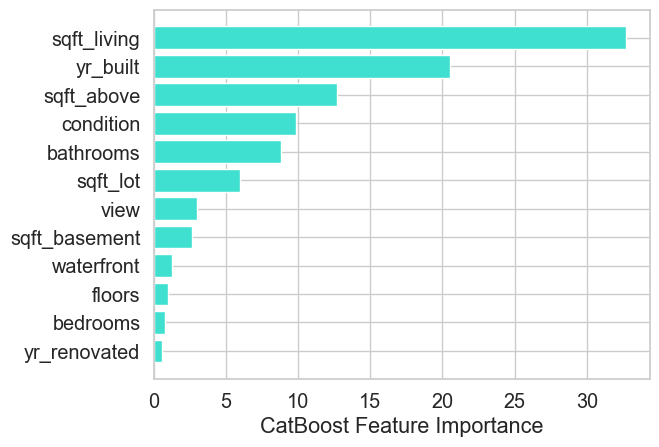

In [21]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(df.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

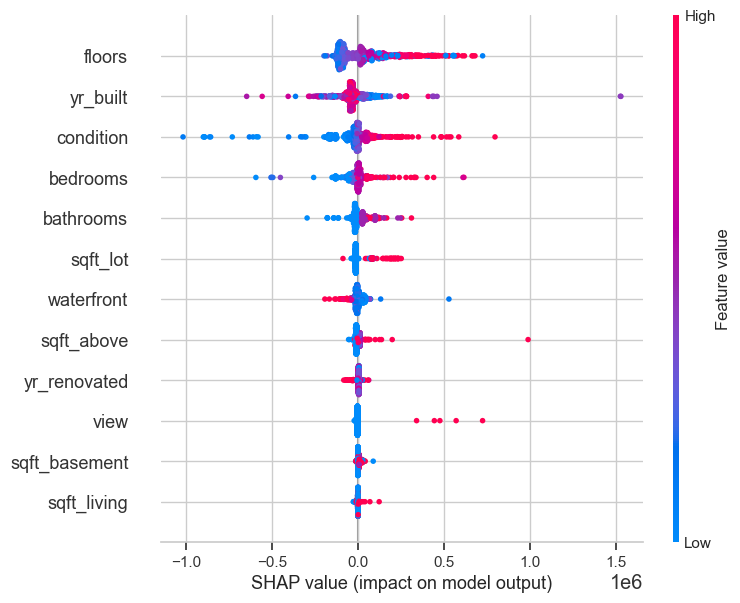

In [22]:

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names = df.columns[sorted_feature_importance])

## Linear regression model

In [23]:
model = LinearRegression(fit_intercept=True)  # объявляем модель
model.fit(X_train, y_train)  # обучаем

LinearRegression()

In [24]:
test_preds = model.predict(X_test)

In [25]:
def mean_absolute_percentage_error(y_true, y_pred):
    return 100 * (np.abs(y_true - y_pred) / y_true).mean()
mean_absolute_percentage_error(y_test, test_preds)


32.71493578272733

In [26]:
train_preds = model.predict(X_train)

metrics.mean_squared_error(y_train, train_preds) ** 0.5, \
metrics.mean_absolute_error(y_train, train_preds), \
mean_absolute_percentage_error(y_train, train_preds)

(538408.1764009825, 167730.85737939284, 34.70237081504666)

In [28]:
metrics.mean_squared_error(y_test, test_preds) ** 0.5, \
metrics.mean_absolute_error(y_test, test_preds), \
mean_absolute_percentage_error(y_test, test_preds)

(233674.23222274258, 152989.50932013858, 32.71493578272733)